# **Transformer Interpretability Beyond Attention Visualization**

In [1]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git Transformer_Explainability

Cloning into 'Transformer_Explainability'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 362 (delta 104), reused 69 (delta 65), pack-reused 235
Receiving objects: 100% (362/362), 3.24 MiB | 3.28 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [2]:
!pip install einops timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 6.3 MB/s 


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [4]:
#@title WSSS4LUAD class indices to names
%%capture
CLS2IDX = {0: 'tumor',
           1: 'stroma',
           2: 'normal',}

In [5]:
os.chdir(f'./Transformer_Explainability')

# **ViT examples**

In [6]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP


In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


In [8]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize(resized),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy())

In [9]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print 3 predictions
    prob = torch.sigmoid(predictions)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [10]:
test_image_path_1  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/436219-7159-48987-[1, 1, 0].png'
test_image_path_2  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/439448-38035-50808-[0, 1, 0].png'
valid_image_path   = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/0000-[0, 1, 1].png'
valid_mask_path    = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00_1.png'

In [11]:
test_image_1 = cv2.imread(test_image_path_1)
test_image_1 = cv2.resize(test_image_1, (224, 224))

test_image_2 = cv2.imread(test_image_path_2)
test_image_2 = cv2.resize(test_image_2, (224, 224))

valid_image  = cv2.imread(valid_image_path)
valid_image  = cv2.resize(valid_image, (224, 224))

valid_mask   = cv2.imread(valid_mask_path)
valid_mask   = cv2.resize(valid_mask, (224, 224))

In [12]:
test_image_1_tensor = preprocess_image(test_image_1).to(device)
test_image_2_tensor = preprocess_image(test_image_2).to(device)
valid_image_tensor  = preprocess_image(valid_image).to(device)

In [13]:
# initialize ViT pretrained
model = vit_LRP(pretrained=False, num_classes = 3).cuda()

model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/accu_cutmix_aug_model_vit_base_patch16_224_01.pth',
                                                      map_location=torch.device(device)))
model.eval()

attribution_generator = LRP(model)

## Test image 1

In [14]:
output = model(test_image_1_tensor.unsqueeze(0).cuda())
print_top_classes(output)

3 classes:
	0 : tumor 		value = 8.649	 prob = 100.0%
	1 : stroma		value = 3.577	 prob = 97.3%
	2 : normal		value = -6.412	 prob = 0.2%


In [15]:
# tumor - the predicted class
tumor = generate_visualization(test_image_1_tensor)

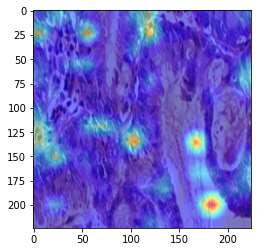

In [16]:
plt.imshow(tumor)

In [17]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_1_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_1_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

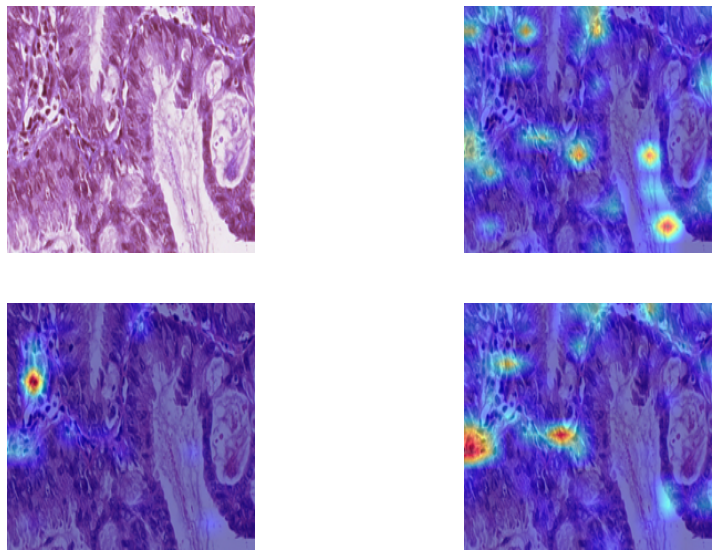

In [18]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_1)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Test image 2

In [19]:
output = model(test_image_2_tensor.unsqueeze(0).cuda())
print_top_classes(output)

3 classes:
	1 : stroma		value = 10.306	 prob = 100.0%
	0 : tumor 		value = -3.934	 prob = 1.9%
	2 : normal		value = -6.328	 prob = 0.2%


In [20]:
# tumor - the predicted class
tumor = generate_visualization(test_image_2_tensor)

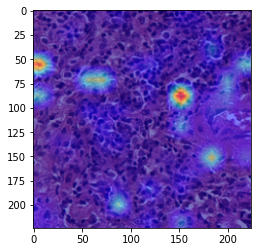

In [21]:
plt.imshow(tumor)

In [22]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_2_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_2_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

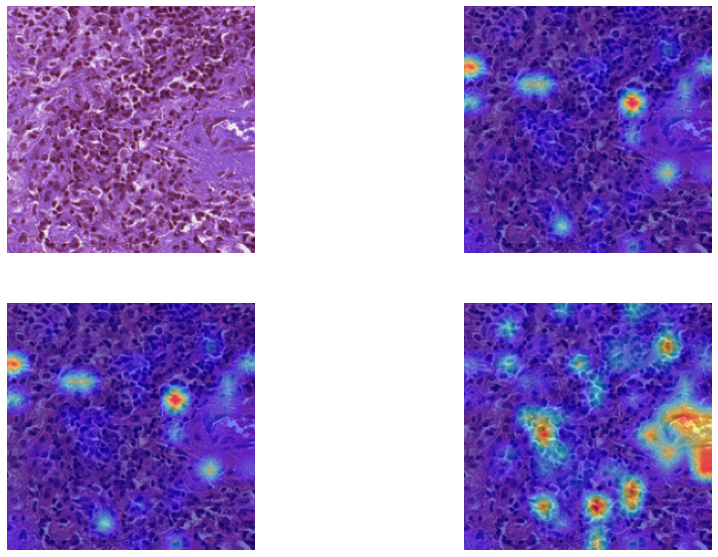

In [23]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_2)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Valid Image

In [24]:
output = model(valid_image_tensor.unsqueeze(0).cuda())
print_top_classes(output)

3 classes:
	1 : stroma		value = 14.835	 prob = 100.0%
	2 : normal		value = 7.189	 prob = 99.9%
	0 : tumor 		value = -6.788	 prob = 0.1%


In [25]:
# tumor - the predicted class
tumor = generate_visualization(valid_image_tensor)

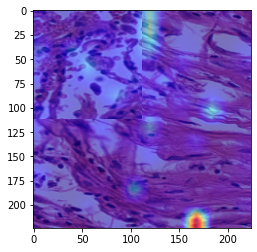

In [26]:
plt.imshow(tumor)

In [27]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(valid_image_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(valid_image_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

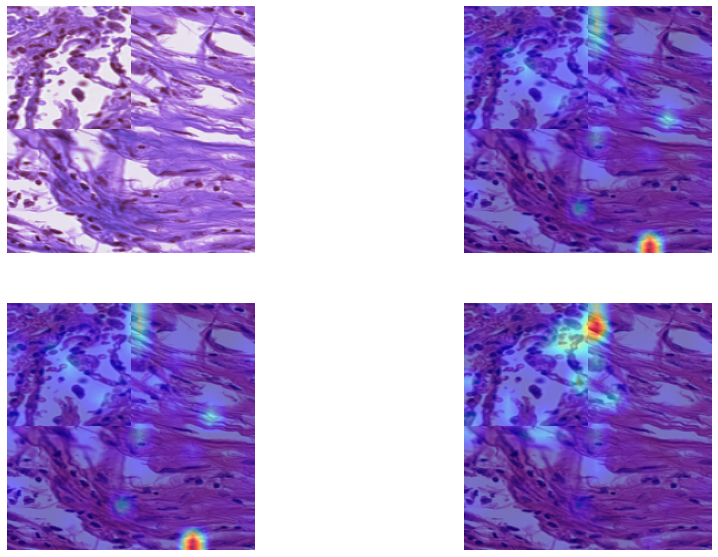

In [28]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(valid_image)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

# **DeiT examples**

In [29]:
from baselines.ViT.ViT_LRP import deit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# initialize ViT pretrained with DeiT
model = vit_LRP(pretrained=False, num_classes = 3).cuda()
model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_deit_base_patch16_224_01.pth',
                                                      map_location=torch.device(device)))

FileNotFoundError: ignored

In [ ]:
model.eval()
attribution_generator = LRP(model)


normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

## Test image 1

In [ ]:
output = model(test_image_1_tensor.unsqueeze(0).cuda())
print_top_classes(output)

In [ ]:
# tumor - the predicted class
tumor = generate_visualization(test_image_1_tensor)

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_1_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_1_tensor, class_index=2)

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_1)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Test image 2

In [ ]:
output = model(test_image_2_tensor.unsqueeze(0).cuda())
print_top_classes(output)

In [ ]:
# tumor - the predicted class
tumor = generate_visualization(test_image_2_tensor)

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_2_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_2_tensor, class_index=2)

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_2)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Valid Image

In [ ]:
output = model(valid_image_tensor.unsqueeze(0).cuda())
print_top_classes(output)

In [ ]:
# tumor - the predicted class
tumor = generate_visualization(valid_image_tensor)

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(valid_image_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(valid_image_tensor, class_index=2)

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(valid_image)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

# Check

In [ ]:
img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/447079-10698-56947-[0, 0, 1].png'

In [ ]:
image = cv2.imread(img)
image = cv2.resize(image, (224, 224))

In [ ]:
image_tensor = preprocess_image(image)

In [ ]:
output = model(valid_image_tensor.unsqueeze(0).cuda())
print_top_classes(output)

In [ ]:
torch.sigmoid(output).cpu().detach().numpy()

In [ ]:
accuracy_score(np.array([[0., 0., 1.]]), torch.sigmoid(output).cpu().detach().numpy())